# PHYS465: Coursework Exercise 1 : Solutions

## The Problem

The World Happiness Report is published every year by the Sustainable Development Solutions Network (SDSN). 
This dataset uses polling to estimate the 'happiness' of people across the globe. 
Download the catalogue (from 2023) here: https://raw.githubusercontent.com/MatSmithAstro/phys465_2025_resources/main/coursework/datasets/happiness_score.csv or from Moodle.


The catalogue contains the happiness scores (and an associated uncertainty) for each country along with 6 other variables : 
 * `Logged GDP per capita`: The logarithm of the countrys gross domestic product (GDP) per capita.
 * `Social support`: A measure of the perceived social support in the country.
 * `Life expectancy`: The average number of years a person is expected to live in the country.
 * `Freedom to make choices`: The degree to which individuals think they have freedom.
 * `Generosity`: The level of generosity reported by individuals in the country. 
 * `Corruption`: The perception of corruption within the country
 * `Dystopia`: The hypothetical happiness score in a dystopian society. This is used as a reference point.


***

In [1]:
# Load libraries of interest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

### Q1. Load the dataset into a pandas dataframe; Calculate mean/median happiness (1 mark)

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/MatSmithAstro/phys465_2025_resources/main/coursework/datasets/happiness_score.csv')
print(f'(mean, median) happiness = ({np.mean(df.HappinessScore):0.2f}, {np.median(df.HappinessScore):0.2f})')

(mean, median) happiness = (5.54, 5.69)


### Q2. Fit a straight between `logGDP` and `happiness` including uncertainties. Return the best-fitting values (4 marks)
 * Marks are awarded for:
    * correctly fitting the function (1 mark)
        * including uncertainties (1 mark)
    * returning the fitted values (1 mark)
        * including calculated uncertainties (1 mark)

In [3]:
# First define a linear function
def straight_line(x, intercept=0, slope=0):
    return intercept + slope*x
# Use the curve_fit routine to fit this function considering the measured uncertainties
opt, cov, info,_,_= optimize.curve_fit(straight_line, df.LoggedGDP, df.HappinessScore, \
                                       sigma=df.HappinessError, absolute_sigma=True, \
                                       full_output=True)
# Calculate uncertainty on the parameters
fit_uncertainties = np.sqrt(np.diag(cov))
print(f'Line of best-fit is {opt[0]:0.3f} + {opt[1]:0.3f}*x')
print(f'Recovered uncertainties are {fit_uncertainties[0]:0.3f} and {fit_uncertainties[1]:0.3f}')

Line of best-fit is -3.100 + 0.910*x
Recovered uncertainties are 0.117 and 0.012


### 3. Produce a plot of `GDP per capita` v `happiness` (6 marks).
 * Include both the associated error bars and line-of-best-fit
***
 * The plot itself is worth 2 marks
 * Further marks are lost if any of the following are omitted:
    * error bars, a legend, an easy to read best-fit model, and easy to read axis labels (including the log term)
 * NB: plotting in natural units (i.e. an exponential function) is acceptable _if_ the best-fit line is correspondingly adapted 

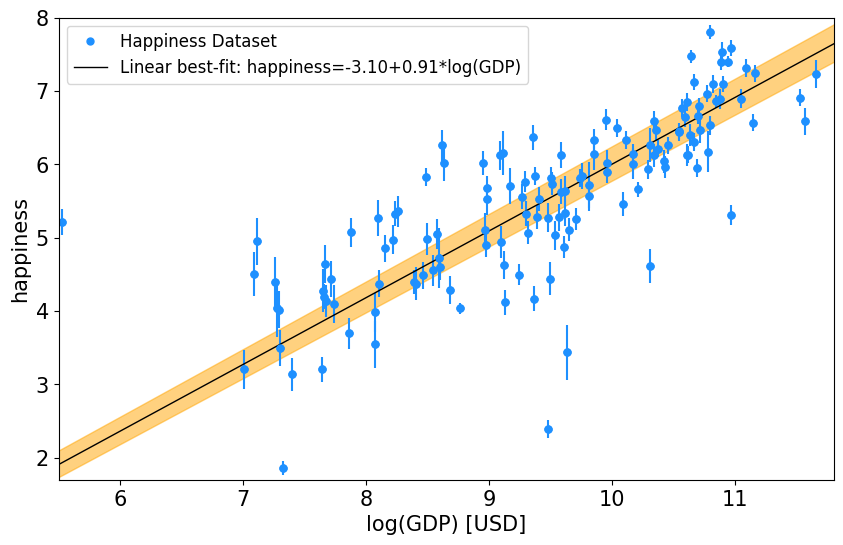

In [4]:
dummy_x = np.arange(5,12,0.1)
fig   = plt.figure(figsize=[10,6])
grid  = fig.add_gridspec(ncols=1, nrows=1, width_ratios=[1], height_ratios=[1], \
                         wspace=0.0, hspace=0.1)
ax1   = fig.add_subplot(grid[0,0])
_     = ax1.plot(df.LoggedGDP, df.HappinessScore, \
                 marker='o', ls='', color='dodgerblue', ms=5, label='Happiness Dataset')
_     = ax1.errorbar(df.LoggedGDP, df.HappinessScore, yerr=df.HappinessError, \
                     fmt='o', ls='', color='dodgerblue', ms=5)
_     = ax1.plot(dummy_x, straight_line(dummy_x, *opt), color='black', lw=1, ls='-', \
                 label=f'Linear best-fit: happiness={opt[0]:0.2f}+{opt[1]:0.2f}*log(GDP)')
_     = ax1.fill_between(dummy_x, straight_line(dummy_x, *opt-fit_uncertainties), straight_line(dummy_x, *opt+fit_uncertainties), \
                        color='orange', alpha=0.5) 
_     = ax1.legend(loc='upper left', fancybox=True, fontsize=12)
_     = ax1.set_ylabel('happiness', fontsize=15)
_     = ax1.set_xlabel('log(GDP) [USD]', fontsize=15)
_     = ax1.tick_params(which='major', axis='both', labelsize=15)
_     = ax1.set_ylim(1.7, 8.0)
_     = ax1.set_xlim(5.5, 11.8)

### Q4. Write **your own function** to calculate the $\chi^2$ & $\chi^2_{red}$ statistics (8 marks)
 * Between a given dataset (with uncertainties) and an input model
***
 * NB: The question does not specify the input model: the function should be an input 
 * Marks are awarded for:
   * the functions (5 marks):
     * if two separate functions have been used then -1 if one does not call the other
     * -1 if the model is not a defined input (i.e. if calculated model values are an input)
     * -1 if the parameters of the model are not a defined input
     * -1 if a FOR loop is used to calculate the $\chi^2$
   * comments (2 marks)
   * sensible variable names (1 mark)


In [5]:
# chi^2      = sum((data-model)**2/sigma**2)
# chi^2_red  = chi^2/n_dof
def chi2(x_vals, y_vals, y_errs, model, *model_params):
    """Function to calculate chi2 given measured data points (x_vals, y_vals), uncertainties (errs) and an input model (model, *model_params)"""
    if len(x_vals)!=len(y_vals):
        print('ERROR : n_x!=n_y')
        return np.NaN
    chi2 = np.sum(((y_vals-model(x_vals, *model_params))**2)/y_errs**2)
    return chi2
def chi2_red(x_vals, y_vals, y_errs, model, *model_params):
    """Function to calculate chi2_red given measured data points (x_vals, y_vals), uncertainties (errs) and an input model (model, *model_params)"""
    chisqr     = chi2(x_vals, y_vals, y_errs, model, *model_params)
    chi2_red   = chisqr/(len(y_vals)-len(model_params))
    return chi2_red

### Q5. Calculate $\chi^2_{red}$ for your best-fitting happiness v logGDP model (4 marks)
 * Marks are lost for
   * printed values with too high precision (1 mark)
   * no comments (1 mark) 

In [6]:
# --- #
fitted_chi2 = chi2_red(df.LoggedGDP, df.HappinessScore, df.HappinessError, straight_line, *opt)
print(f'chi2_red_min = {fitted_chi2:0.2f}')
print(f'NB: scipy.optimize estimates {np.sum(info["fvec"]**2)/len(df):0.2f}')

chi2_red_min = 23.42
NB: scipy.optimize estimates 23.08


### Q6. Select another suitable functional form (10 marks)
 * Perform a least-squares fit and calculate $\chi^2$.
 * Print and visualise the results.
 * Which model is favoured, and why?
***
 * Marks are awarded for:
   * Motivating a suitable function (1 mark)
   * Writing a function that defines it (2 marks)
      * NB: this function should include comments
   * Fitting to the data (1 mark)
   * Calculating $\chi^2_{red}$ (2 marks)
      * The function defined above should be used (-1 otherwise)
   * Visualing the results (3 marks)
     * The plot should contain the linear model (-1 if not)
   * Determining the better model (with an explanation) (1 mark)  

In [7]:
# Looking at the data I see some evidence that the data is only linear for highGDP
# -> maybe a higher-order polynomial would be preferable lets test that
# (Lots of different functions are viable choices)
def quadratic(x, intercept, linear_term, quad_term):
    """Function to calculate a quadratic function given input values"""
    return intercept + linear_term*x + quad_term*x**2
def cubic(x, intercept, linear_term, quad_term, cubic_term):
    """Function to calculate a cubic function given input values"""
    return intercept + linear_term*x + quad_term*x**2 + cubic_term*x**3
# -- #
# Let's fit the functions
opt_quad, cov_quad        = optimize.curve_fit(quadratic, df.LoggedGDP, df.HappinessScore, \
                                               sigma=df.HappinessError, absolute_sigma=True)
uncertainties_quad        = np.sqrt(np.diag(cov_quad))
opt_cub, cov_cub          = optimize.curve_fit(cubic, df.LoggedGDP, df.HappinessScore, \
                                               sigma=df.HappinessError, absolute_sigma=True)
uncertainties_cub         = np.sqrt(np.diag(cov_cub))
fitted_chi2_quad          = chi2_red(df.LoggedGDP, df.HappinessScore, df.HappinessError, quadratic, *opt_quad)
fitted_chi2_cubic         = chi2_red(df.LoggedGDP, df.HappinessScore, df.HappinessError, cubic, *opt_cub)
print(f'chi2_min (linear) = {fitted_chi2:0.2f}')
print(f'chi2_min (quadratic) = {fitted_chi2_quad:0.2f}')
print(f'chi2_min (cubic) = {fitted_chi2_cubic:0.2f}')
# Conclusion: All 3 models give similar chi2_red's; none explain the scatter observed 
# This implies that there are additional variables that must be considered 
# There is also no evidence for a more complicated model 

chi2_min (linear) = 23.42
chi2_min (quadratic) = 22.43
chi2_min (cubic) = 21.58


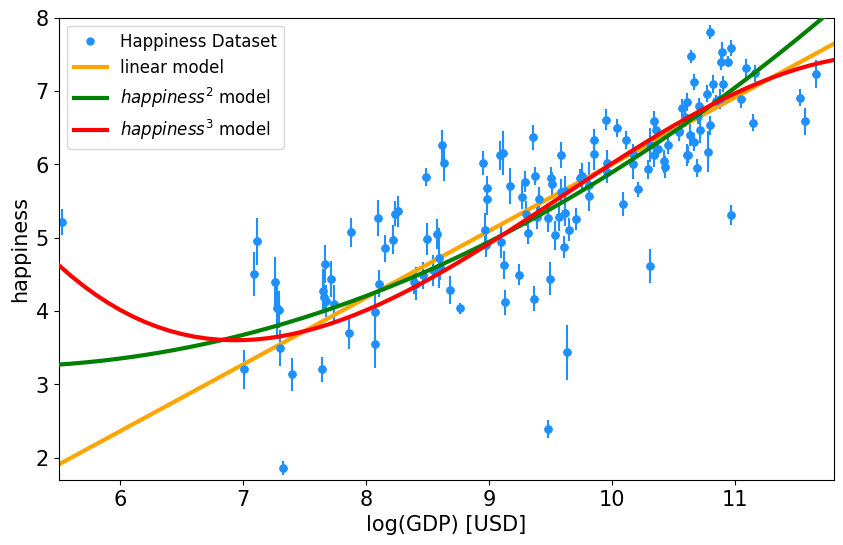

In [8]:
dummy_x      = np.arange(5,12,0.1)
fig          = plt.figure(figsize=[10,6])
grid         = fig.add_gridspec(ncols=1, nrows=1, width_ratios=[1], height_ratios=[1], \
                                wspace=0.0, hspace=0.1)
ax1          = fig.add_subplot(grid[0,0])
# --------- #
# Visualise the data
_            = ax1.plot(df.LoggedGDP, df.HappinessScore, \
                        marker='o', ls='', color='dodgerblue', ms=5, label='Happiness Dataset')
_            = ax1.errorbar(df.LoggedGDP, df.HappinessScore, yerr=df.HappinessError, \
                            fmt='o', ls='', color='dodgerblue', ms=5)
# Visualise the models
label_linear = r'linear model'
label_quad   = r'${happiness}^2$ model'
label_cubic  = r'${happiness}^3$ model'
_     = ax1.plot(dummy_x, straight_line(dummy_x, *opt), color='orange', lw=3, ls='-', \
                 label=label_linear)
_     = ax1.plot(dummy_x, quadratic(dummy_x, *opt_quad), color='green', lw=3, ls='-', \
                 label=label_quad, zorder=5)
_     = ax1.plot(dummy_x, cubic(dummy_x, *opt_cub), color='red', lw=3, ls='-', \
                 label=label_cubic, zorder=6)

_     = ax1.legend(loc='upper left', fancybox=True, fontsize=12)
_     = ax1.set_ylabel('happiness', fontsize=15)
_     = ax1.set_xlabel('log(GDP) [USD]', fontsize=15)
_     = ax1.tick_params(which='major', axis='both', labelsize=15)
_     = ax1.set_ylim(1.7, 8.0)
_     = ax1.set_xlim(5.5, 11.8)

### Q7 Calculate the best-fit linear relationship between happiness and social support. Which model is favoured, and why? (6 marks)
 * NB: 'which model is favoured' means comparing the resuts from `logged GDP` to those of `social support`. It can also be interpreted as comparing multiple models with social support
***
 * Marks are awarded for:
   * Calculating the best-fit relationship (1 mark)
   * Calculating $\chi^2_{red}$ (2 marks)
      * The function defined above should be used (-1 otherwise)
   * Visualing the results (2 marks)
      * This is not explicitly requested, but is needed to confirm that the function is valid
   * Determining the better model (with an explanation) (1 mark)  

In [9]:
# Use the curve_fit routine to fit a linear function with Social Support as the independent variable
opt_ss, cov_ss, info,_,_= optimize.curve_fit(straight_line, df.SocialSupport, df.HappinessScore, \
                                       sigma=df.HappinessError, absolute_sigma=True, \
                                       full_output=True)
# Calculate uncertainty on the parameters
fit_uncertainties_ss = np.sqrt(np.diag(cov_ss))
print(f'Line of best-fit is {opt_ss[0]:0.3f} + {opt_ss[1]:0.3f}*x')
print(f'Recovered uncertainties are {fit_uncertainties_ss[0]:0.3f} and {fit_uncertainties_ss[1]:0.3f}')
print('')
# --- 
# Calculate chi2_red for this model
fitted_chi2_ss = chi2_red(df.SocialSupport, df.HappinessScore, df.HappinessError, straight_line, *opt_ss)
print(f'chi2_red_min(Social Support) = {fitted_chi2_ss:0.2f}')
print(f'chi2_red_min(Logged GDP) = {fitted_chi2:0.2f}')
# Social support has a significantly smaller chi2 and is this favoured 
print(f'Favoured model is Social Support, but note that Social Support is highly correlated with Logged GDP')

Line of best-fit is -0.973 + 8.249*x
Recovered uncertainties are 0.082 and 0.097

chi2_red_min(Social Support) = 14.32
chi2_red_min(Logged GDP) = 23.42
Favoured model is Social Support, but note that Social Support is highly correlated with Logged GDP


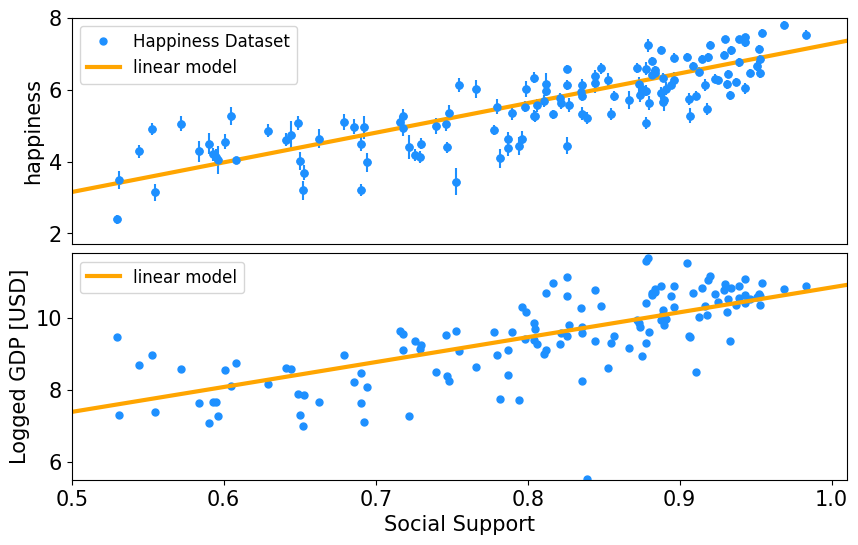

In [10]:
dummy_x      = np.arange(0,2,0.1)
fig          = plt.figure(figsize=[10,6])
grid         = fig.add_gridspec(ncols=1, nrows=2, width_ratios=[1], height_ratios=[1,1], \
                                wspace=0.0, hspace=0.04)
# --------- #
ax1          = fig.add_subplot(grid[0,0])
# Visualise the data
_            = ax1.plot(df.SocialSupport, df.HappinessScore, \
                        marker='o', ls='', color='dodgerblue', ms=5, label='Happiness Dataset')
_            = ax1.errorbar(df.SocialSupport, df.HappinessScore, yerr=df.HappinessError, \
                            fmt='o', ls='', color='dodgerblue', ms=5)
# Visualise the models
label_linear = r'linear model'
_     = ax1.plot(dummy_x, straight_line(dummy_x, *opt_ss), color='orange', lw=3, ls='-', \
                 label=label_linear)
_     = ax1.legend(loc='upper left', fancybox=True, fontsize=12)
_     = ax1.set_ylabel('happiness', fontsize=15)
_     = ax1.set_xlabel('Social Support', fontsize=15)
_     = ax1.tick_params(which='major', axis='both', labelsize=15)
_     = ax1.set_ylim(1.7, 8.0)
_     = ax1.set_xlim(0.5, 1.01)
_     = ax1.get_xaxis().set_visible(False)
# --------- #
# Also plot Social Support v logGDP
ax1          = fig.add_subplot(grid[1,0])
# Determine the best-fit model
opt_gdp, cov_gdp, info,_,_= optimize.curve_fit(straight_line, df.SocialSupport, df.LoggedGDP, full_output=True)
_            = ax1.plot(df.SocialSupport, df.LoggedGDP, \
                        marker='o', ls='', color='dodgerblue', ms=5)
_     = ax1.plot(dummy_x, straight_line(dummy_x, *opt_gdp), color='orange', lw=3, ls='-', \
                 label=label_linear)
_     = ax1.legend(loc='upper left', fancybox=True, fontsize=12)
_     = ax1.set_ylabel('Logged GDP [USD]', fontsize=15)
_     = ax1.set_xlabel('Social Support', fontsize=15)
_     = ax1.tick_params(which='major', axis='both', labelsize=15)
_     = ax1.set_ylim(5.5, 11.8)
_     = ax1.set_xlim(0.5, 1.01)

***
# Extension (15 marks)

* 8 marks for additional investigations
   * This includes motivation and interpretation
   * NB: Marks are lost for excess plots where information can be expressed through one.
* 7 marks for interpretation

### Ext 1 : Consider how the relationship between happiness and GDP varies globally

In [11]:
# Find all of the available regions
regions = df.Global_Region.unique()
print(f'There are {len(regions)} different regions')

There are 6 different regions


In [12]:
# Loop over each one, fit the linear relationship and calculate the chi2
for reg in regions:
    df_reg            = df[df.Global_Region==reg]
    opt_reg, cov_reg  = optimize.curve_fit(straight_line, df_reg.LoggedGDP, df_reg.HappinessScore, \
                                           sigma=df_reg.HappinessError, absolute_sigma=True)
    fitted_chi2       = chi2_red(df_reg.LoggedGDP, df_reg.HappinessScore, df_reg.HappinessError, straight_line, *opt_reg)

    print(f'{reg:18}: (slope, chi2_red) = ({opt_reg[1]:0.2f}; {fitted_chi2:0.2f})')
    print(f'                    (mean, min, max, no) = ({df_reg.HappinessScore.mean():0.2f}, {df_reg.HappinessScore.min():0.2f}, {df_reg.HappinessScore.max():0.2f}), {len(df_reg)}')
    

Asia              : (slope, chi2_red) = (1.04; 24.55)
                    (mean, min, max, no) = (5.19, 1.86, 6.59), 21
Europe            : (slope, chi2_red) = (1.11; 10.24)
                    (mean, min, max, no) = (6.54, 5.25, 7.80), 37
Africa            : (slope, chi2_red) = (0.76; 25.06)
                    (mean, min, max, no) = (4.59, 2.39, 7.47), 46
LatinAmerica      : (slope, chi2_red) = (0.25; 3.72)
                    (mean, min, max, no) = (5.97, 5.21, 6.61), 19
CIS               : (slope, chi2_red) = (0.06; 7.45)
                    (mean, min, max, no) = (5.59, 5.07, 6.14), 9
NorthAmerica_ANZ  : (slope, chi2_red) = (-0.54; 0.48)
                    (mean, min, max, no) = (7.02, 6.89, 7.12), 4


### Results: 
 * the most correlated region is _Europe_
 * NorthAmerica_ANZ, CIS, LatinAmerica show lower dependence
 * Asia and Africa return high chi2 => lower dependence; happiness also spans the largest range 

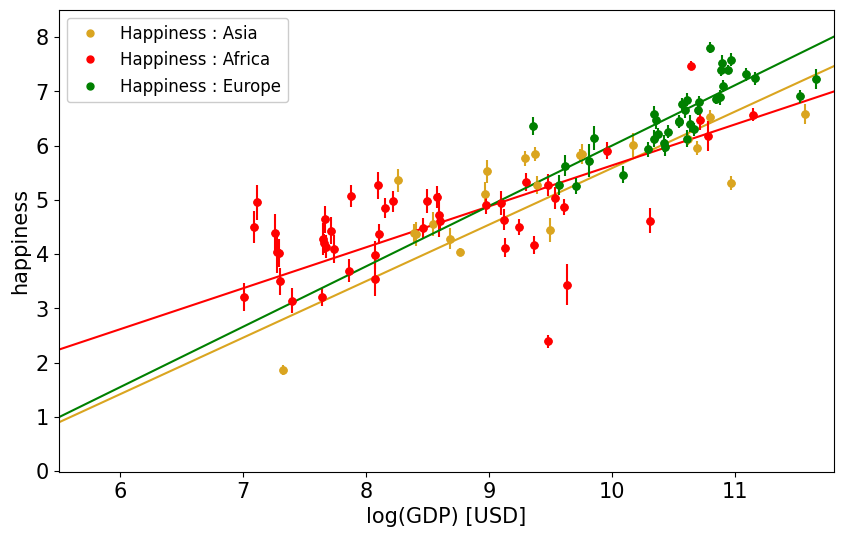

In [13]:
# Let's plot some of the results
dummy_x = np.arange(5,12,0.1)
fig     = plt.figure(figsize=[10,6])
grid    = fig.add_gridspec(ncols=1, nrows=1, width_ratios=[1], height_ratios=[1], \
                           wspace=0.0, hspace=0.1)
ax1     = fig.add_subplot(grid[0,0])
# 
selected_regions = ['Asia', 'Africa', 'Europe']
region_colors    = ['goldenrod', 'red', 'green']
region_symbol    = ['o','o','o']
for n, reg in enumerate(selected_regions):
    # For each region, plot the countries and the line-of-best-fit
    subsample    = df[df.Global_Region==reg]       
    _            = ax1.plot(subsample.LoggedGDP, subsample.HappinessScore, \
                            marker=region_symbol[n], ls='', color=region_colors[n], ms=5, label=f'Happiness : {reg}')
    _            = ax1.errorbar(subsample.LoggedGDP, subsample.HappinessScore, yerr=subsample.HappinessError, \
                                fmt=region_symbol[n], ls='', color=region_colors[n], ms=5)
    opt_reg, cov_reg  = optimize.curve_fit(straight_line, subsample.LoggedGDP, subsample.HappinessScore, \
                                           sigma=subsample.HappinessError, absolute_sigma=True)
    _            = ax1.plot(dummy_x, straight_line(dummy_x, *opt_reg), color=region_colors[n])


_     = ax1.legend(loc='upper left', fancybox=True, fontsize=12, framealpha=1.0)
_     = ax1.set_ylabel('happiness', fontsize=15)
_     = ax1.set_xlabel('log(GDP) [USD]', fontsize=15)
_     = ax1.tick_params(which='major', axis='both', labelsize=15)
_     = ax1.set_xlim(5.5, 11.8)

### Ext 1 : Consider the correlation between other parameters and happiness.

In [14]:
# Find all of the available parameters
parameters = df.columns.drop({'Country', 'HappinessScore','HappinessError','Global_Region','Region'})
print(f'There are {len(parameters)} different parameters')
print(parameters)

There are 6 different parameters
Index(['LoggedGDP', 'SocialSupport', 'LifeExpectancy', 'FreedomtomakeChoices',
       'Generosity', 'Corruption'],
      dtype='object')


In [15]:
# Loop over each one, fit the linear relationship and calculate the chi2
from scipy.stats import pearsonr
for p in parameters:
    opt_p, cov_p     = optimize.curve_fit(straight_line, df[p], df.HappinessScore, \
                                           sigma=df.HappinessError, absolute_sigma=True)
    fitted_chi2      = chi2_red(df[p], df.HappinessScore, df.HappinessError, straight_line, *opt_p)
    corr             = pearsonr(df[p], df.HappinessScore)
    print(f'{p:20}: (slope, chi2_red, correlation_coeff) = ({opt_p[1]:0.2f}, {fitted_chi2:0.2f}, {corr.statistic:0.2f})')


LoggedGDP           : (slope, chi2_red, correlation_coeff) = (0.91, 23.42, 0.78)
SocialSupport       : (slope, chi2_red, correlation_coeff) = (8.25, 14.32, 0.84)
LifeExpectancy      : (slope, chi2_red, correlation_coeff) = (0.18, 28.74, 0.75)
FreedomtomakeChoices: (slope, chi2_red, correlation_coeff) = (7.27, 35.95, 0.66)
Generosity          : (slope, chi2_red, correlation_coeff) = (1.75, 65.70, 0.04)
Corruption          : (slope, chi2_red, correlation_coeff) = (-3.40, 46.75, -0.47)


### Results: 
 * Social support has the best and tightest correlation
 * Generosity is anti correlated
 * Are the linear relationships valid?

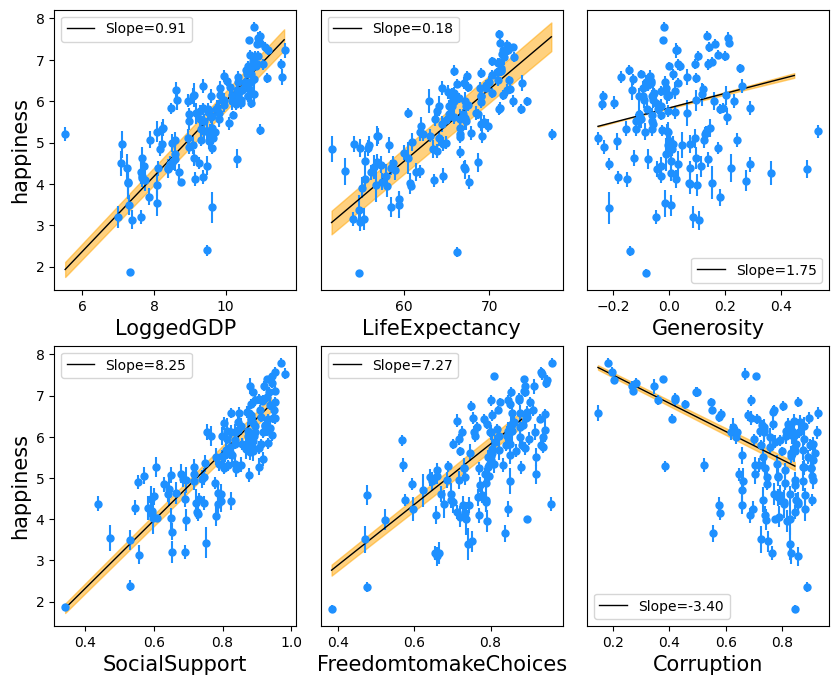

In [16]:
fig   = plt.figure(figsize=[10,8])
grid  = fig.add_gridspec(ncols=3, nrows=2, width_ratios=[1,1,1], height_ratios=[1, 1], wspace=0.1, hspace=0.2)
n_x, n_y = 0, 0
for p in parameters:
    ax1   = fig.add_subplot(grid[n_x, n_y])
    _     = ax1.errorbar(df[p], df.HappinessScore, yerr=df.HappinessError, \
                        fmt='o', ls='', color='dodgerblue', ms=5)
    opt_p, cov_p     = optimize.curve_fit(straight_line, df[p], df.HappinessScore, \
                                          sigma=df.HappinessError, absolute_sigma=True)
    fit_uncertainties = np.sqrt(np.diag(cov_p))
    dummy_x = np.arange(df[p].min(),df[p].max(),0.1)
    _       = ax1.plot(dummy_x, straight_line(dummy_x, *opt_p), color='black', lw=1, ls='-', \
                       label=f'Slope={opt_p[1]:0.2f}')
    _       = ax1.fill_between(dummy_x, straight_line(dummy_x, *opt_p-fit_uncertainties), \
                               straight_line(dummy_x, *opt_p+fit_uncertainties), \
                               color='orange', alpha=0.5) 

    _     = ax1.set_ylabel('happiness', fontsize=15)
    _     = ax1.set_xlabel(f'{p}', fontsize=15)
    _     = ax1.legend()
    if n_y!=0: _ = ax1.get_yaxis().set_visible(False)
    n_x    += 1
    if n_x==2:
        n_x = 0
        n_y +=1

### Results
 * The correlations are seemingly linear for Logged GDP, Social Support and Life Expectancy
 * Generosity is seemingly uncorrelated
 * Freedom to make choices and Corruption seem to be you either have them or you don't

In [17]:
# A multidimensional fit. 
def sixdimensional_linear(df, intercept=0, slope_gdp=0, slope_ss=0, slope_le=0, slope_fc=0, slope_g=0, slope_c=0):
    """Function to fit a multi-dimensional parameter space. Input is df"""
    return intercept + df.LoggedGDP*slope_gdp + df.SocialSupport*slope_ss + df.LifeExpectancy*slope_le + df.FreedomtomakeChoices*slope_fc + df.Generosity*slope_g + df.Corruption*slope_c
    
# Extension: consider the improvement over a model with just 3 variables
def threedimensional_linear(df, intercept=0, slope_gdp=0, slope_ss=0, slope_c=0):
    """Function to fit a multi-dimensional parameter space. Input is df"""
    return intercept + df.LoggedGDP*slope_gdp + df.SocialSupport*slope_ss + df.Corruption*slope_c

In [18]:
# Use the curve_fit routine to fit this function considering the measured uncertainties
opt_6, cov_6, info,_,_= optimize.curve_fit(sixdimensional_linear,df, df.HappinessScore, [0,0,0,0,0,0,0], \
                                       sigma=df.HappinessError, absolute_sigma=True, \
                                       full_output=True)
fit_uncertainties_6 = np.sqrt(np.diag(cov_6))
fitted_chi2_6     = chi2_red(df, df.HappinessScore, df.HappinessError, sixdimensional_linear, *opt_6)
variables         = ['LoggedGDP', 'SocialSupport', 'LifeExpectancy', 'FreedomtomakeChoices', 'Generosity', 'Corruption']
print('Our 6 parameter model has the following coefficients')
for i in range(0,6):
    print(f'{variables[i]:20}: {opt_6[i+1]:0.2f}±{fit_uncertainties_6[i+1]:0.2f}')
print('')
# Use the curve_fit routine to fit the 3D function considering the measured uncertainties
opt_3, cov_3, info,_,_= optimize.curve_fit(threedimensional_linear,df, df.HappinessScore, [0,0,0,0], \
                                       sigma=df.HappinessError, absolute_sigma=True, \
                                       full_output=True)
fit_uncertainties_3 = np.sqrt(np.diag(cov_3))
fitted_chi2_3     = chi2_red(df, df.HappinessScore, df.HappinessError, threedimensional_linear, *opt_3)
variables         = ['LoggedGDP', 'SocialSupport', 'Corruption']
print('Our 3 parameter model has the following coefficients')
for i in range(0,3):
    print(f'{variables[i]:20}: {opt_3[i+1]:0.2f}±{fit_uncertainties_3[i+1]:0.2f}')
print('')

print(f'6D: chi2_red = {fitted_chi2_6:0.2f}')
print(f'3D: chi2_red = {fitted_chi2_3:0.2f}')

Our 6 parameter model has the following coefficients
LoggedGDP           : 0.23±0.03
SocialSupport       : 5.00±0.18
LifeExpectancy      : 0.01±0.00
FreedomtomakeChoices: 1.93±0.15
Generosity          : 0.08±0.11
Corruption          : -0.87±0.08

Our 3 parameter model has the following coefficients
LoggedGDP           : 0.23±0.02
SocialSupport       : 6.11±0.15
Corruption          : -1.25±0.07

6D: chi2_red = 8.21
3D: chi2_red = 9.37


## Statement
 * marks are awarded for:
    * summary of a result (ideally including a statistic) (3 marks)
    * physical inference (3 marks)
    * a discussion of uncertainties or future extensions (3 marks)
 * NB: scientific language should be used. marks can also be awarded for deductions outside of the above scope

**Example**:

"When looking the relationship betweeen happiness and GDP, a strong positive correlation is observed across European countries ($\text{slope}=1.11$), but an anti correlation ($\text{slope}=-0.54$) is observed for other developed countries such as the US and ANZ. Very little evidence of a positive correlation is observed for the former Soviet republics. 
Looking at the data, the correlations can only really be observed over large dynamic ranges, resulting in large uncertainties for the "US+NZ" sample. The dispersion on the data and high $\chi^{2}_{\text{dof}}\,$ implies that while GDP is strongly related to happiness, other variables also play a role. 
For an extension, it would be interesting to look at these correlations for different development indices, to study how this trend has evolved over time and search for outlying countries to search for additional parameters of interest."

### Q8. Additional Marks (6 marks)

* Marks are awarded for:
  * Well structured notebooks that run (i.e. that include markdown comments) (2 marks)
  * Functions that are well written (i.e. comments and well named variables) (2 marks)
  * Plots that are well presented (2 marks)
* Marks can be lost for:
  * An over-reliance on for loops (i.e. for dataset manipulation)
  * An excessive use of variables (i.e. over-slicing)
* Marks can also be obtained for evidence of excellent coding or visualisation


***

### General feedback

The vast majority of submissions were very good, but a few mistakes were commonly found throughout. In particular:

* The use of pandas or np.array() is specifically designed to eliminate for loops over the entire dataset. This was routinely found when functions were defined. This will really slow down the code when additional loops are needed.
* When plotting a model, it is always preferable to use evenly spaced, monotonic data points (i.e. not the dataset).
  * These can be defined using np.arange() and np.linspace()
* When calculating a statistic please make sure that it matches your expectation given previous results. In this case, there were several $\chi^2$ values that were clearly incompatible with the plotted results
* When plotting lots of similar results consider how best to convey your results to the reader.
  * 10 near identical plots can easily be compressed.
  * It is trivial with matplotlib to customise plots. Consider axis ratios, colors, linestyles, transparency, fonts, ...
* When making a choice (e.g. of a functional form to consider) remember to motivate why you are choosing it.
* It's a useful skill to define default variables in a function. This significantly increases flexibility.
* Be aware of what your function is trying to achieve: an over-complicated function should be a function inside a function
* For the interpretation remember to include:
   * What we found (i.e. one or several values)
   * What it means
   * What might be the cause of the relationship discovered
   * How we could test it? I.e. other statistical tests or datasets that would be informative